# Assignment 4
- Donwload  ziptrain.csv and ziptest.csv datasets from  https://github.com/vahidpartovinia/ycbs255/

# Digit learning challenge
- Use the methods taught in the course, or a good combination of the methods taught in the course to predict all 10 digits of the zipcode data. Only use ziptrain.csv data to build your model, and evaluate the accuracy of your model on ziptest.csv 

- Your codes must be reproducible. We may run your codes on ziptrain.csv data on our own machine. 

# Submission note
Please fill this jupyter notebook. Extract the pdf file as follows. On  Jupyter manue go to File/Print Preview, then on Browser menu go to File/Print. 

## Only PDF  Submissions will be graded


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

# load training and test data
path='data/'
filename1=path+'ziptrain.csv'
zipdata=np.loadtxt(filename1)

filename2=path+'ziptest.csv'
ziptest=np.loadtxt(filename2)

X_train=zipdata[:,1:]
y_train=zipdata[:,0]
X_test=ziptest[:,1:]
y_test=ziptest[:,0]

## 1.1 Random Forest

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rf=RandomForestClassifier(n_estimators=100,random_state=1)
cross_val_score(rf,X_train,y_train,cv=10).mean()

0.96750473199816089

In [3]:
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
score=accuracy_score(y_test,y_pred)
score

0.94020926756352763

## 1.2 SVM

In [4]:
from sklearn.svm import SVC
svm=SVC(random_state=21)
cross_val_score(svm,X_train,y_train,cv=10).mean()

0.97299441552267363

In [5]:
svm.fit(X_train,y_train)
y_pred=svm.predict(X_test)
score=accuracy_score(y_test,y_pred)
score

0.9422022919780767

## 1.3 MLPClassifier

In [6]:
from sklearn.neural_network import MLPClassifier
mlpc=MLPClassifier(random_state=4)
cross_val_score(mlpc,X_train,y_train,cv=10).mean()

0.97175027193232122

In [7]:
mlpc.fit(X_train,y_train)
y_pred=mlpc.predict(X_test)
score=accuracy_score(y_test,y_pred)
score

0.94120577977080222

## 1.4 kNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier
Krange=np.arange(2,15)
scores=np.zeros(13)
for k in Krange:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores[k-2]=cross_val_score(knn,X_train,y_train,cv=5).mean() 

Text(0,0.5,'Accuracy')

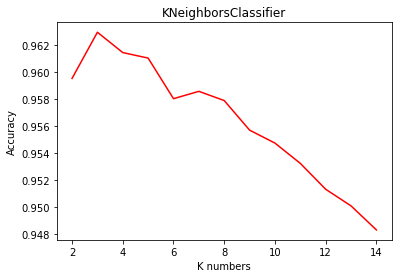

In [9]:
plt.plot(np.arange(2,15),scores,'r-')
plt.title('KNeighborsClassifier' )
plt.xlabel('K numbers')
plt.ylabel('Accuracy')

When k=3, kNN has the best performance

In [10]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
score=accuracy_score(y_test,y_pred)
score

0.94469357249626307

As shown above, the KNeighborsClassifier(k=3) tops the list of these basic classifiers with a test accuracy of 0.94469, followed by SVM (0.9422)。 MLPC comes the third 0.9412, and Random Forest is the last 0.9402.

## 1.5 Residual Neural Network

Residual Network is a deep network based on Convoulutional Neural Network. The residual learning framework eases the training of 
these networks,and enables them to be substantially deeper — leading to improved performance in both visual and non-visual tasks.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from torchvision import transforms as tfs

#Hyper Parameters
EPOCH=80
BATCH_SIZE=100
LR=0.001
Modelname='ResNet.pkl'

In [10]:
#construct ResNet
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,downsample=None):
        super(ResidualBlock,self).__init__()
        self.res1=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,stride,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
        )
        self.relu=nn.ReLU(inplace=True)
        self.downsample=downsample

    def forward(self,x):
        residual=x
        out=self.res1(x)
        if self.downsample:
            residual=self.downsample(x)
        out+=residual
        out=self.relu(out)
        return out

# ResNet Module
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=10):
        super(ResNet, self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(1,20,5,1,2),
            nn.BatchNorm2d(20),
            nn.ReLU()
        )
        self.in_channels = 20
        self.layer1=self.make_layer(block,20,blocks=layers[0])
        self.layer2=self.make_layer(block,40,blocks=layers[1],stride=2)
        self.layer3=self.make_layer(block,80,blocks=layers[2],stride=2)
        self.avg_pool=nn.AvgPool2d(4)
        self.fn=nn.Linear(80,num_classes)
    def make_layer(self,block,out_channnels,blocks,stride=1):
        downsample=None
        if (stride != 1) or (self.in_channels != out_channnels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,out_channnels,3,stride=stride,padding=1),
                nn.BatchNorm2d(out_channnels)
            )
        layers=[]
        layers.append(block(self.in_channels,out_channnels,stride=stride,downsample=downsample))
        self.in_channels=out_channnels
        for i in range(1,blocks):
            layers.append(block(out_channnels,out_channnels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out=self.conv1(x)
        out=self.layer1(out)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.avg_pool(out)
        out=out.view(out.size(0),-1)
        out=self.fn(out)
        return out

res_layers=[4,10,4]
resnet=ResNet(ResidualBlock,res_layers).cuda()       #GPU
optimizer=torch.optim.Adam(resnet.parameters(),lr=LR)   #optimize all cnn parameters
loss_func=nn.CrossEntropyLoss()

In [11]:
# data agumention
transform = tfs.Compose([
    tfs.ToPILImage(),
    tfs.RandomRotation(180,expand=True),
    tfs.RandomResizedCrop(16,scale=(0.8,1.2)),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor()]
)

In [12]:
#loading data
path='data/'
filename1=path+'ziptrain.csv'
zipdata=np.loadtxt(filename1)

filename2=path+'ziptest.csv'
ziptest=np.loadtxt(filename2)

np.random.shuffle(zipdata)
train_data, valid_data= train_test_split(zipdata, test_size=0.1,random_state=4)
valid_num = valid_data.shape[0]

# transform training data from numpy to tensor, bundling
train_x = train_data[:, 1:].reshape(-1, 16, 16)
train_x = torch.from_numpy(train_x)  # transfo.type(torch.FloatTensor)rm to tensor from
train_x = torch.unsqueeze(train_x, dim=1).type(torch.FloatTensor)
train_num = train_x.shape[0]
train_y = train_data[:, 0]
train_y = torch.from_numpy(train_y).type(torch.LongTensor)
dataset = Data.TensorDataset(train_x, train_y)

# transform validation data from numpy to tensor
valid_x = valid_data[:, 1:].reshape(-1, 16, 16)
valid_x = torch.from_numpy(valid_x).type(torch.FloatTensor)  # transform to tensor from
valid_x = Variable(torch.unsqueeze(valid_x, dim=1), volatile=True).cuda()

valid_y = valid_data[:, 0]
valid_y = torch.from_numpy(valid_y).type(torch.LongTensor).cuda()
del train_data
del valid_data

In [13]:
best_validation_accuracy = 0.0
last_improvement = 0
require_improvement =3000
total_iterations = 0
break_signal=0
b_x=torch.zeros((BATCH_SIZE,1,16,16))
accs=[]

#training and testing
for epoch in range(EPOCH):
    train_loader = Data.DataLoader(dataset=dataset,batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
    for step,(x,y) in enumerate(train_loader):
        for i in range(BATCH_SIZE):
            b_x[i] = transform(x[i])
        b_x=Variable(x).cuda()     #GPU
        b_y=Variable(y).cuda()     #GPU
        total_iterations+=1
        output=resnet(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()   #clear gradients for this training step
        loss.backward()         #backpropagation,compute gradients
        optimizer.step()        #apply gradients
        if step%20==0:
            valid_output =resnet(valid_x).cuda()
            pred_y = torch.max(valid_output, 1)[1].cuda().data.squeeze()
            accuracy=sum(pred_y==valid_y)/valid_num
            accs.append(accuracy)

            if accuracy > best_validation_accuracy:  # capture the model of highest presicion
                best_validation_accuracy = accuracy
                last_improvement = total_iterations
                torch.save(resnet, path+Modelname)
        if total_iterations - last_improvement > require_improvement:
            print("End training, as there is no inprovement for a long time!")
            break_signal=1
            break
    if break_signal: break
    if (epoch + 1) % 30 == 0:
        LR /=2
        optimizer = torch.optim.Adam(resnet.parameters(), lr=LR)

C:\Users\sjun1\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\sjun1\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0 Step: 0 |train loss: 2.3024420738220215 |valid accuracy: 0.19041095890410958
Epoch: 0 Step: 20 |train loss: 0.5931494235992432 |valid accuracy: 0.8794520547945206
Epoch: 0 Step: 40 |train loss: 0.2817847430706024 |valid accuracy: 0.9671232876712329
Epoch: 0 Step: 60 |train loss: 0.15861625969409943 |valid accuracy: 0.9657534246575342
Epoch: 1 Step: 0 |train loss: 0.1522427797317505 |valid accuracy: 0.963013698630137
Epoch: 1 Step: 20 |train loss: 0.08110488206148148 |valid accuracy: 0.9698630136986301
Epoch: 1 Step: 40 |train loss: 0.26341521739959717 |valid accuracy: 0.9780821917808219
Epoch: 1 Step: 60 |train loss: 0.022509107366204262 |valid accuracy: 0.9767123287671233
Epoch: 2 Step: 0 |train loss: 0.06494288891553879 |valid accuracy: 0.9849315068493151
Epoch: 2 Step: 20 |train loss: 0.018535947427153587 |valid accuracy: 0.9835616438356164
Epoch: 2 Step: 40 |train loss: 0.059712883085012436 |valid accuracy: 0.9726027397260274
Epoch: 2 Step: 60 |train loss: 0.08098568022251

Epoch: 23 Step: 20 |train loss: 0.00010369301162427291 |valid accuracy: 0.9958904109589041
Epoch: 23 Step: 40 |train loss: 0.0001947545970324427 |valid accuracy: 0.9958904109589041
Epoch: 23 Step: 60 |train loss: 0.00014189719513524324 |valid accuracy: 0.9945205479452055
Epoch: 24 Step: 0 |train loss: 0.0002992725349031389 |valid accuracy: 0.9931506849315068
Epoch: 24 Step: 20 |train loss: 0.00029587268363684416 |valid accuracy: 0.9972602739726028
Epoch: 24 Step: 40 |train loss: 0.0007219553226605058 |valid accuracy: 0.9972602739726028
Epoch: 24 Step: 60 |train loss: 0.0001964616822078824 |valid accuracy: 0.9972602739726028
Epoch: 25 Step: 0 |train loss: 0.0003273439360782504 |valid accuracy: 0.9972602739726028
Epoch: 25 Step: 20 |train loss: 0.0003471803793217987 |valid accuracy: 0.9986301369863013
Epoch: 25 Step: 40 |train loss: 0.0011081122793257236 |valid accuracy: 0.9986301369863013
Epoch: 25 Step: 60 |train loss: 0.00024958132416941226 |valid accuracy: 0.9986301369863013
Epoch: 2

Epoch: 46 Step: 20 |train loss: 0.0020725964568555355 |valid accuracy: 0.9904109589041096
Epoch: 46 Step: 40 |train loss: 0.0002481269766576588 |valid accuracy: 0.9917808219178083
Epoch: 46 Step: 60 |train loss: 0.0004487276019062847 |valid accuracy: 0.9904109589041096
Epoch: 47 Step: 0 |train loss: 0.0005193996476009488 |valid accuracy: 0.9917808219178083
Epoch: 47 Step: 20 |train loss: 0.0032065415289252996 |valid accuracy: 0.9917808219178083
Epoch: 47 Step: 40 |train loss: 0.0002647113869898021 |valid accuracy: 0.989041095890411
Epoch: 47 Step: 60 |train loss: 0.0003568553947843611 |valid accuracy: 0.9904109589041096
Epoch: 48 Step: 0 |train loss: 0.00011231422104174271 |valid accuracy: 0.9917808219178083
Epoch: 48 Step: 20 |train loss: 0.00021629333787132055 |valid accuracy: 0.9931506849315068
Epoch: 48 Step: 40 |train loss: 0.00015152453852351755 |valid accuracy: 0.9931506849315068
Epoch: 48 Step: 60 |train loss: 0.00022480488405562937 |valid accuracy: 0.9945205479452055
Epoch: 49

Epoch: 69 Step: 20 |train loss: 6.612777360714972e-05 |valid accuracy: 0.9972602739726028
Epoch: 69 Step: 40 |train loss: 9.092330583371222e-05 |valid accuracy: 0.9972602739726028
Epoch: 69 Step: 60 |train loss: 5.0578117225086316e-05 |valid accuracy: 0.9972602739726028
Epoch: 70 Step: 0 |train loss: 0.00017564772861078382 |valid accuracy: 0.9972602739726028
Epoch: 70 Step: 20 |train loss: 6.864070746814832e-05 |valid accuracy: 0.9972602739726028
Epoch: 70 Step: 40 |train loss: 2.7503967430675402e-05 |valid accuracy: 0.9958904109589041
Epoch: 70 Step: 60 |train loss: 0.00017629146168474108 |valid accuracy: 0.9958904109589041
Epoch: 71 Step: 0 |train loss: 5.402088208938949e-05 |valid accuracy: 0.9958904109589041
Epoch: 71 Step: 20 |train loss: 0.00010256767563987523 |valid accuracy: 0.9958904109589041
End optimization, as there is no inprovement for a long time!


In [14]:
#check the performace of ResNet
resnet=torch.load(path+Modelname)
valid_output =resnet(valid_x).cuda()
pred_y = torch.max(valid_output, 1)[1].cuda().data.squeeze()
accuracy=sum(pred_y==valid_y)/valid_num
print('Valid accuracy',accuracy)

Valid accuracy 0.9986301369863013


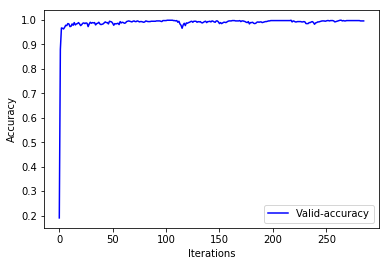

In [15]:
plt.plot(accs,'b-',label='Valid-accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.legend()

In [16]:
# Calculate test accuracy
test_x=ziptest[:,1:].reshape(-1,16,16)
test_x=torch.from_numpy(test_x).type(torch.FloatTensor)     #transform to tensor from
test_x=Variable(torch.unsqueeze(test_x,dim=1),volatile=True).cuda()
test_y=ziptest[:,0]

valid_output = resnet(test_x)
pred_y = torch.max(valid_output, 1)[1].cuda().data.squeeze()
pred_y=pred_y.cpu()
pred_y=pred_y.numpy()

from sklearn.metrics import accuracy_score
score=accuracy_score(test_y,pred_y)
print(score)

0.976581963129


###### The highest accuracy achieved by Residual Neural Network in test dataset is 0.97658, which is higher than that of KNN,SVM, Random Forest and MLPC